```
UEF 2022: Color Science Lab Session02 Labwork
Author: Austin Ryan English
```

In [2]:
from lib.Spectral import Spectral
from lib.CSL_homework_1 import read_envi
from lib.plot import plot
from lib.CSL_homework_2 import spim2rgb
from matplotlib import pyplot as plt
from colour import SpectralDistribution, SpectralShape
from colour.plotting import plot_multi_sds
from matplotlib.gridspec import GridSpec
from numpy import array, ascontiguousarray, ndarray
from cv2 import circle, imread
from prettytable import PrettyTable

[ 396.55  401.43  406.31  411.2   416.09  420.98  425.88  430.78  435.69
  440.6   445.52  450.44  455.36  460.29  465.22  470.16  475.1   480.05
  484.99  489.95  494.9   499.87  504.83  509.8   514.77  519.75  524.73
  529.72  534.71  539.71  544.7   549.71  554.71  559.73  564.74  569.76
  574.78  579.81  584.84  589.88  594.92  599.96  605.01  610.06  615.12
  620.18  625.25  630.31  635.39  640.47  645.55  650.63  655.72  660.82
  665.91  671.02  676.12  681.23  686.35  691.47  696.59  701.72]


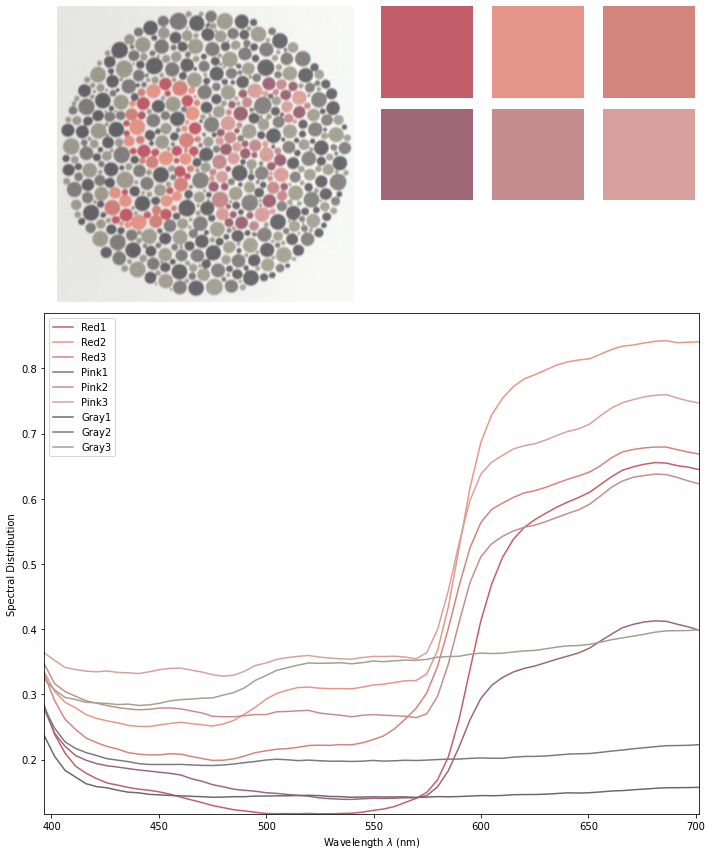

In [13]:
PATH_TO_HSI_DIR = './hsi/ishihara/capture'
BASE_HSI_FILENAME = 'page_scan_0007'
DOMAIN = [400, 700]
# TASK 1
#   compare renderings under various light sources
hsi = Spectral(
    read_envi(f'{PATH_TO_HSI_DIR}/{BASE_HSI_FILENAME}'),
    read_envi(f'{PATH_TO_HSI_DIR}/WHITEREF_{BASE_HSI_FILENAME}'),
    read_envi(f'{PATH_TO_HSI_DIR}/DARKREF_{BASE_HSI_FILENAME}'),
    crop=[98,640,670,1212],
    scale=1,
    trim=DOMAIN
)
print(hsi.wavelengths)
color_locations = [['Red', (922,322), (917, 295), (894, 250)],
                ['Pink', (1004,296), (966,383), (1052,370)],
                   ['Gray', (1051,211), (892,126),(986,196)]]

EXTRACT_RADIUS=5
fig = plt.figure(constrained_layout=True, figsize=(10,12))
gs = GridSpec(8, 6, figure=fig)
ax1 = plt.subplot(gs[0:3,0:3])
rgb_ishihara = ascontiguousarray(spim2rgb(hsi.im, hsi.wavelengths, 'D65'))
plot(rgb_ishihara, save='ishihara.png',fig=ax1)

patch_sds = []
patch_rgb = []
rgb_table = PrettyTable()

for idx,set in enumerate(color_locations):
    sds = [SpectralDistribution(domain=hsi.wavelengths, data=hsi.get_spectra(loc, EXTRACT_RADIUS), name=f'{set[0]}{idx+1}') for idx, loc in enumerate(set[1:])]
    
    for i, sd in enumerate(sds):
        rgb = spim2rgb(sd.values, sd.domain, 'D65')
        plt.imsave(f'session02lab_results/rgb_sample{i}_set{idx}.png', rgb)
        rgb_table.add_column(f'rgb_sample{i}_set{idx}_', array(rgb).flatten())
    
    patch_sds.append(sds)
    rgbs = [spim2rgb(sd.values, hsi.wavelengths, 'D65') for sd in sds]
    patch_rgb.append(rgbs)

with open(f'session02lab_results/sample_rgb.csv', 'w', newline='') as f_output:
    f_output.write(rgb_table.get_csv_string())
    

for set_idx in range(len(color_locations)-1):
    for patch_idx in range(len(color_locations[0])-1):
        ax = plt.subplot(gs[set_idx,(3+patch_idx)])
        plot(patch_rgb[set_idx][patch_idx], fig=ax)


ax = plt.subplot(gs[3:,:])
plot_multi_sds([p for set in patch_sds for p in set], axes=ax, plot_kwargs=[{'color': rgb[0,0,:]} for set in patch_rgb for rgb in set])

# define patch pairs for which dE needs to be minimized or maximized
# set indexes to compare
comparisons = [[0,2],[1,2]]
sd_pairs = [[patch_sds[pair[0]][idx], patch_sds[pair[1]][idx], f'patch{idx}_sets{pair[0]}{pair[1]}'] for idx in range(0, len(color_locations[0])-1) for pair in comparisons]

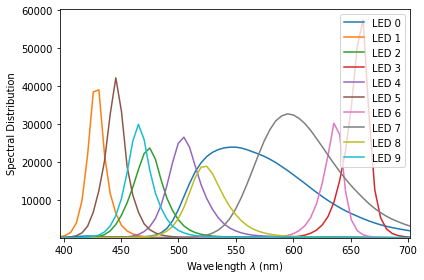

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [16]:
# Read LED Spectra
import glob
from colour import SpectralDistribution, SpectralShape, MultiSpectralDistributions
from colour.plotting import plot_multi_sds
from numpy import loadtxt
from lib.interpolate import interpolate
LED_SPD_DIR = './spds/stls_leds'
LED_FILENAMES = glob.glob(f'{LED_SPD_DIR}/*.txt')

led_spds = []
for idx, spd_file in enumerate(LED_FILENAMES):
    data = loadtxt(spd_file)
    interpolated = interpolate(data[:,1], data[:,0], hsi.wavelengths)
    sd = SpectralDistribution(domain=hsi.wavelengths, data=interpolated, name=f'LED{idx:2}')
    led_spds.append(sd)

led_spds = MultiSpectralDistributions(led_spds)
    
plot_multi_sds(led_spds)


In [17]:
# Initialize PSO
from lib.pso import PSO, PSO_MODE
from math import inf
from numpy import repeat, newaxis, sum, multiply, array, ndarray, c_, mean, clip
from lib.color_difference import deltaE, deltaRGB, michelson_contrast, rgb2gray
from lib.CSL_homework_2 import XYZ2Lab, spim2XYZ
from lib.animate_video import animate
from enum import Enum

# LED Convex Spectra
led_spds_aligned = led_spds.align(SpectralShape(400,700,1))
num_led_wavelength_samples = len(led_spds_aligned.domain)
led_wavelengths = led_spds_aligned.domain
def generate_convex_spectra(weights): 
    weight_mat = repeat(array(weights)[:, newaxis], num_led_wavelength_samples, axis=1)
    mult = multiply(weight_mat.T, led_spds_aligned.values)
    sd = SpectralDistribution(domain=led_wavelengths, data=sum(mult, axis=1), name='Convex Spectra')
    return sd
min = 0
max = 1
parameter_data = [(f'LED{i:2}', min, max) for i in range(0,10)]

# align sd pairs to resolution of led samples
sd_shape = SpectralShape(400,700,1)
sd_pairs_align = [[sd1.copy().align(sd_shape), sd2.copy().align(sd_shape), name] for sd1,sd2,name in sd_pairs]
interpolated_wavelengths = sd_shape.range()

class COST_METHODS(Enum):
    DE_MIN = 0
    DE_MAX = 1
    DRGB_MIN = 2
    DRGB_MAX = 3
    MICH_CONTR_MIN = 4
    MICH_CONTR_MAX = 5
    
def mean_metric(metricFn, data):
    res = []
    for d in data:
        res.append(metricFn(d))
    return mean(array(res))

def dE(r1, r2, convex_spectra='D65'):
    xyz1 = spim2XYZ(r1, interpolated_wavelengths, lsource=convex_spectra)
    lab01 = XYZ2Lab(xyz1)
    lab02 = XYZ2Lab(spim2XYZ(r2, interpolated_wavelengths, lsource=convex_spectra))
    return deltaE(lab01, lab02)[0,0]

def dRGB(r1, r2, convex_spectra='D65'):
    rgb1 = spim2rgb(r1, interpolated_wavelengths, lsource=convex_spectra)
    rgb2 = spim2rgb(r2, interpolated_wavelengths, lsource=convex_spectra)
    return deltaRGB(rgb1, rgb2)

def mich_contrast(r1, r2, convex_spectra='D65'):
    rgb1 = spim2rgb(r1, interpolated_wavelengths, lsource=convex_spectra)
    rgb2 = spim2rgb(r2, interpolated_wavelengths, lsource=convex_spectra)
    return michelson_contrast(rgb2gray(rgb1), rgb2gray(rgb2))

_cost_methods = [
    [COST_METHODS.DE_MIN, dE, PSO_MODE.MIN],
    [COST_METHODS.DE_MAX, dE, PSO_MODE.MAX],
    [COST_METHODS.DRGB_MIN, dRGB, PSO_MODE.MIN],
    [COST_METHODS.DRGB_MAX, dRGB, PSO_MODE.MAX],
    [COST_METHODS.MICH_CONTR_MIN, mich_contrast, PSO_MODE.MIN],
    [COST_METHODS.MICH_CONTR_MAX, mich_contrast, PSO_MODE.MAX]
]

cost_methods = {}
for c in _cost_methods:
    cost_methods[c[0]] = (c[0], c[1],c[2])
    
COST_METHOD=cost_methods[COST_METHODS.MICH_CONTR_MIN]

def COST_FN(params): 
    illum = generate_convex_spectra(params)
    mean_error = mean_metric(lambda data: COST_METHOD[1](data[0].values, data[1].values, illum.values), sd_pairs_align)
    return mean_error

# num_iter = 60
# n_particles = 200
num_iter = 20
n_particles = 30

params_sum_to_1 = lambda params: [p/sum(params) for p in params]
no_negative = lambda params: clip(params, 0, None)
constraints = [no_negative, params_sum_to_1]

pso = PSO(
    param_data=parameter_data,
    cost_fn=COST_FN,
    n_particles=n_particles,
    n_iter=num_iter,
    c0=.8,
    c1=0.5,
    c2=0.5,
    mode=COST_METHOD[2],
    constraints=constraints
)

shape = list(range(400, 700, 1))

fig = plt.figure(figsize=(20,10))
ax1 = plt.axes(xlim=(400, 700), ylim=(0,60000))
line, = ax1.plot([], [], lw=2)
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

plotlays, plotcols = [2], ["black","red"]
lines = []
for index in range(0, n_particles):
    lobj = ax1.plot([],[],lw=0.5,color='blue')[0]
    lines.append(lobj)

lines.append(ax1.plot([],[],lw=2,color='red')[0])

def init():
    for line in lines:
        line.set_data([],[])
    return lines

# on each pso iteration, update plot scatter
print('Iteration: ', end='')
def pso_loop(i):
    pso.next()

    print(i, end=' ')
    
    weights = pso.get_particle_positions()
    y = array([interpolate(generate_convex_spectra(w).values, led_wavelengths, shape) for w in weights]).flatten()
    
    for lnum,line in enumerate(lines):
        
        if lnum == len(lines) - 1:
            w = pso.position_best
        else:
            w = weights[lnum]
            
        line.set_data(shape, interpolate(generate_convex_spectra(w).values, led_wavelengths, shape)) # set data for each line separately. 
        
filename = f'session02lab_results/{COST_METHOD[0].name}/{COST_METHOD[0].name}.gif'
animate(fig, pso_loop, num_iter, filename, 10)

best = (pso.position_best, pso.cost_best)
print()
print(best[0])

Iteration: 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
[0.0, 0.028692012732062469, 0.67518490258499197, 0.020412892985577996, 0.0017804147678455102, 0.00014603933891419474, 4.2149423090470928e-05, 0.0, 0.031092756281210242, 0.24264883188630709]


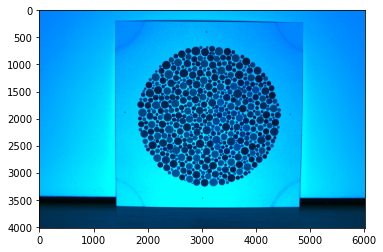

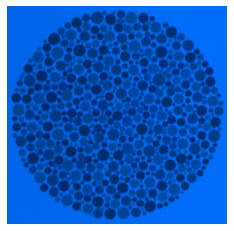

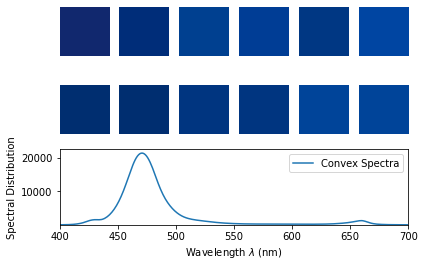

In [20]:
from numpy import hstack, zeros, savetxt, nan, amin, amax
import rawpy

IMPLEMENTED_ILLUM_RAW_IM_DIR = 'session02lab_results/ishihara_optimal_raw'
illum_raw_im = rawpy.imread(f'{IMPLEMENTED_ILLUM_RAW_IM_DIR}/{COST_METHOD[0].name}.cr2')
# illum_rgb = illum_raw_im.postprocess(gamma=(1, 1), no_auto_bright=True, output_bps=16, use_camera_wb=False, use_auto_wb=False, user_wb=(1, 1, 1, 1))
illum_rgb = illum_raw_im.postprocess(gamma=(1, 1), no_auto_bright=True, output_bps=16)

plt.imshow(illum_rgb/2**16)
x = PrettyTable()
x2 = PrettyTable()

best_spectra = generate_convex_spectra(best[0])
best_spectra_align_to_hsi = SpectralDistribution(domain=hsi.wavelengths, data=interpolate(best_spectra.values, best_spectra.domain, hsi.wavelengths), name='Convex Spectra')

rows = len(best_spectra.domain)

rgb_best = spim2rgb(hsi.im, hsi.wavelengths, lsource=best_spectra_align_to_hsi.values)
max = amax(rgb_best)
min = amin(rgb_best)
plot(rgb_best, fig=plt.figure(), norm=True, doClip=False, save=f'session02lab_results/{COST_METHOD[0].name}/ishihara_best.png')

fig = plt.figure(constrained_layout=True)
gs = GridSpec(3, len(sd_pairs), figure=fig)

for idx, p in enumerate(sd_pairs):
    ax = plt.subplot(gs[0,idx])
    rgb1 = spim2rgb(p[0].values, hsi.wavelengths, lsource=best_spectra_align_to_hsi.values)
    rgb1 = (rgb1 - min)/(max - min)
    plot(rgb1, fig=ax, save=f'session02lab_results/{COST_METHOD[0].name}/rgbbest_{p[2]}_a.png')
    ax = plt.subplot(gs[1,idx])
    rgb2 = spim2rgb(p[1].values, hsi.wavelengths, lsource=best_spectra_align_to_hsi.values)
    rgb2 = (rgb2 - min)/(max - min)
    plot(rgb2, fig=ax, save=f'session02lab_results/{COST_METHOD[0].name}/rgbbest_{p[2]}_b.png')

ax4 = plt.subplot(gs[2,:])
plot_multi_sds([best_spectra], axes=ax4)

x.add_column('wavelength', best_spectra.domain)
x.add_column('best_spectra', best_spectra.values)
x2.add_column('wavelength', best_spectra.domain)
x2.add_column('best_spectra', best_spectra.values)

# SD Reflectance Columns
for setIdx, set in enumerate(patch_sds):
    for sdIdx, sd in enumerate(set):
        x.add_column(f'sd{setIdx}{sdIdx}', sd.copy().interpolate(sd_shape).values)
        
# c_best columns
for pair in sd_pairs_align:
    individual_pair_cbest = COST_METHOD[1](pair[0].values, pair[1].values, best_spectra.values)
    x.add_column(f'cbest_{pair[2]}', [individual_pair_cbest] + ['' for i in range(rows - 1)] )

#c_best_mean column
x.add_column('cbest_mean', [pso.cost_best] + ['' for i in range(rows - 1)])
    
# c_65 columns
c_65 = []
for pair in sd_pairs_align:
    individual_pair_cbest = COST_METHOD[1](pair[0].values, pair[1].values)
    c_65.append(individual_pair_cbest)
    x.add_column(f'c65_{pair[2]}', [individual_pair_cbest] + ['' for i in range(rows - 1)])

#c_d65_mean column
x.add_column('cd65_mean', [mean(c_65)] + ['' for i in range(rows - 1)])
    
# position_best columns
x.add_column('position_best', pso.position_best + ['' for i in range(rows-len(pso.position_best))])

# rgb_best columns
for setIdx,set in enumerate(patch_sds):
    for sdIdx,sd in enumerate(set):
        rgb = spim2rgb(sd.values, hsi.wavelengths, lsource=best_spectra_align_to_hsi.values)
        x.add_column(f'rgbbest_set{setIdx}_sd{sdIdx}', list(array(rgb).flatten()) + ['' for i in range(rows-3)])

# rgb_65 columns
for setIdx,set in enumerate(patch_sds):
    for sdIdx,sd in enumerate(set):
        rgb = spim2rgb(sd.values, hsi.wavelengths)
        x.add_column(f'rgbd65_set{setIdx}_sd{sdIdx}', list(array(rgb).flatten()) + ['' for i in range(rows-3)])
    
with open(f'session02lab_results/{COST_METHOD[0].name}/{COST_METHOD[0].name}.csv', 'w', newline='') as f_output:
    f_output.write(x.get_csv_string())
    
with open(f'session02lab_results/{COST_METHOD[0].name}/{COST_METHOD[0].name}_illum.csv', 'w', newline='') as f_output:
    f_output.write(x2.get_csv_string(header=False, delimiter=' '))